### MiniLM Model Training and Evaluation

#### Overview
This script showcases the process of training and evaluating the MiniLM model (`all-MiniLM-L6-v2`) for detecting definition sentences using the SetFit framework. The model is fine-tuned with augmented training data, and its performance is assessed on validation and test splits.


/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-1-8ada09e9f76d>:33: DeprecationWarning: `SetFit

Starting training...

Epoch 1/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.438800
50,0.394400
100,0.377600
150,0.334200
200,0.286100
250,0.251200
300,0.226200
350,0.186700
400,0.162400
450,0.145000


Validation Metrics after Epoch 1:
  AUC-ROC: 0.9004
  Precision: 0.9118
  Recall: 0.8182
  F1-Score: 0.8624
  F2-Score: 0.8353
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/train_model_epoch_1

Epoch 2/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.001300
50,0.005100
100,0.005100
150,0.003900
200,0.006100
250,0.006100
300,0.005100
350,0.007600
400,0.005700
450,0.006800


Validation Metrics after Epoch 2:
  AUC-ROC: 0.8963
  Precision: 0.9321
  Recall: 0.8055
  F1-Score: 0.8642
  F2-Score: 0.8280
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/train_model_epoch_2

Epoch 3/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000400
50,0.003500
100,0.004100
150,0.003200
200,0.003900
250,0.004600
300,0.004400
350,0.005200
400,0.004100
450,0.004500


Validation Metrics after Epoch 3:
  AUC-ROC: 0.8999
  Precision: 0.9256
  Recall: 0.8143
  F1-Score: 0.8664
  F2-Score: 0.8343
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/train_model_epoch_3


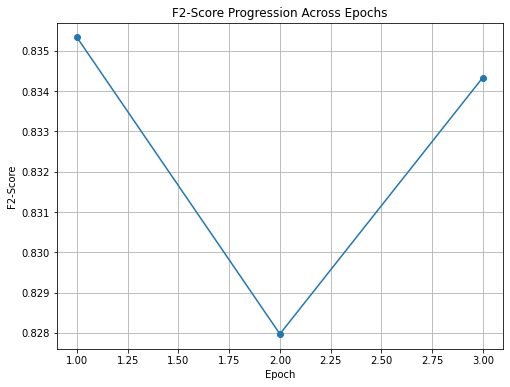

F2-Score progression chart saved at: /home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/f2_scores_progression.png
Final model saved at: /home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/final_trained_model

Test Set Metrics (Final Evaluation):
AUC-ROC: 0.9079
Precision: 0.9126
Recall: 0.8333
F1-Score: 0.8712
F2-Score: 0.8481


In [1]:
import os
import pandas as pd
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/train_split_augmented.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'

train_data = pd.read_csv(train_split_path)
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

# Converting the splits into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

epoch_save_dir = "/home/roland/Projects/saras_folder/Data_Splitting/minilm_aug"
os.makedirs(epoch_save_dir, exist_ok=True)

model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20,
    column_mapping={"sentence_original": "text", "definition_sentence": "label"}
)

f2_scores = []

num_epochs = 3  
print("Starting training...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train() 
    # Evaluation on the validation split
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = trainer.model.predict(val_data['sentence_original'].tolist())
    
    f2 = fbeta_score(val_labels, val_predictions, beta=2)
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"Validation Metrics after Epoch {epoch + 1}:")
    print(f"  AUC-ROC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall: {val_recall:.4f}")
    print(f"  F1-Score: {val_f1:.4f}")
    print(f"  F2-Score: {f2:.4f}")
    
    f2_scores.append(f2)

    model_save_path_epoch = os.path.join(epoch_save_dir, f"train_model_epoch_{epoch + 1}")
    model.save_pretrained(model_save_path_epoch)
    print(f"Model saved at: {model_save_path_epoch}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F2-Score")
plt.title("F2-Score Progression Across Epochs")
plt.grid(True)
progress_chart_path = os.path.join(epoch_save_dir, "f2_scores_progression.png")
plt.savefig(progress_chart_path)
plt.show()
print(f"F2-Score progression chart saved at: {progress_chart_path}")


final_model_path = os.path.join(epoch_save_dir, "final_trained_model")
model.save_pretrained(final_model_path)
print(f"Final model saved at: {final_model_path}")

# Evaluate on the test set
test_labels = test_data['definition_sentence'].tolist()
test_predictions = model.predict(test_data['sentence_original'].tolist())

# Calculate metrics
test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### Graphs and Performance Visualization

The following graphs were generated to visualize the model's performance throughout the training process and evaluate it.

/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


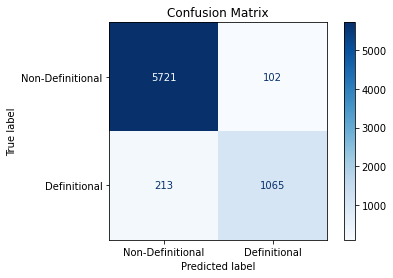


Final Model - Test Set Metrics:
AUC-ROC: 0.9079
Precision: 0.9126
Recall: 0.8333
F1-Score: 0.8712
F2-Score: 0.8481


In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from setfit import SetFitModel
import matplotlib.pyplot as plt

test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
final_model_path = '/home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/final_trained_model'

test_data = pd.read_csv(test_split_path)

final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

# Plotting confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Definitional", "Definitional"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nFinal Model - Test Set Metrics:")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
from datasets import Dataset
from setfit import SetFitModel

val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
model_dir = '/home/roland/Projects/saras_folder/Data_Splitting/minilm_aug'

val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

epoch_metrics = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model_path = os.path.join(model_dir, f"train_model_epoch_{epoch}")
    model = SetFitModel.from_pretrained(model_path)
    
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = model.predict(val_data['sentence_original'].tolist())
    
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')
    val_f2 = fbeta_score(val_labels, val_predictions, beta=2)
    
    epoch_metrics.append({
        "Epoch": epoch,
        "AUC-ROC": val_auc,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-Score": val_f1,
        "F2-Score": val_f2
    })

final_model_path = os.path.join(model_dir, "final_trained_model")
final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

epoch_metrics.append({
    "Epoch": "Test Split",
    "AUC-ROC": test_auc,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "F2-Score": test_f2
})
metrics_df = pd.DataFrame(epoch_metrics)
print(metrics_df)


        Epoch   AUC-ROC  Precision    Recall  F1-Score  F2-Score
0           1  0.900396   0.911765  0.818182  0.862442  0.835329
1           2  0.896297   0.932127  0.805474  0.864185  0.827974
2           3  0.899944   0.925556  0.814272  0.866355  0.834335
3  Test Split  0.907908   0.912596  0.833333  0.871166  0.848065


#### ROC Curve and AUC-ROC Evaluation
The perfromance of the trained model is evaluated by the ROC Curve and the AUC-ROC Score. The ROC Curve is generated by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at many thresholds. And these thresholds determine whether a sentence is a definition or not by representing different decision boundaries.

AUC-ROC: 0.9482


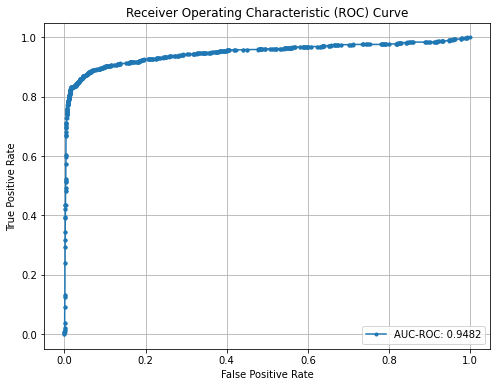

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from setfit import SetFitModel

model_path = '/home/roland/Projects/saras_folder/Data_Splitting/minilm_aug/final_trained_model'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'

test_data = pd.read_csv(test_split_path)

model = SetFitModel.from_pretrained(model_path)
test_labels = test_data['definition_sentence'].tolist()
test_sentences = test_data['sentence_original'].tolist()

#probabilities for the test set
probabilities = model.predict_proba(test_sentences)
# Extraction of probabilities for the definitional sentences
positive_probabilities = probabilities[:, 1]

# Calculating the AUC-ROC
test_auc = roc_auc_score(test_labels, positive_probabilities)
print(f"AUC-ROC: {test_auc:.4f}")

fpr, tpr, thresholds = roc_curve(test_labels, positive_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC: {test_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


______________________________________

### Mpnet Model Training and Evaluation

#### Overview
This code provides a framework for training, evaluating, and saving a classification model for definition detection using the SetFit framework with the MPNet embedding model (`paraphrase-mpnet-base-v2`).

/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-1-2bd03bd247f6>:32: DeprecationWarning: `SetFit

Starting training...

Epoch 1/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.387600
50,0.344800
100,0.295300
150,0.260200
200,0.228100
250,0.176800
300,0.142900
350,0.122700
400,0.109400
450,0.103200


Validation Metrics after Epoch 1:
  AUC-ROC: 0.9133
  Precision: 0.9387
  Recall: 0.8387
  F1-Score: 0.8859
  F2-Score: 0.8570
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/train_model_epoch_1

Epoch 2/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000500
50,0.003000
100,0.005300
150,0.004200
200,0.005800
250,0.005500
300,0.003900
350,0.006500
400,0.005200
450,0.006100


Validation Metrics after Epoch 2:
  AUC-ROC: 0.9140
  Precision: 0.9358
  Recall: 0.8407
  F1-Score: 0.8857
  F2-Score: 0.8581
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/train_model_epoch_2

Epoch 3/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000200
50,0.002700
100,0.003900
150,0.003200
200,0.004100
250,0.004100
300,0.002900
350,0.005200
400,0.004300
450,0.003800


Validation Metrics after Epoch 3:
  AUC-ROC: 0.9105
  Precision: 0.9435
  Recall: 0.8319
  F1-Score: 0.8842
  F2-Score: 0.8520
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/train_model_epoch_3


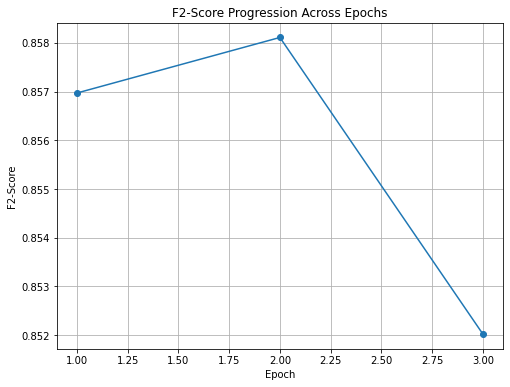

F2-Score progression chart saved at: /home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/f2_scores_progression.png
Final model saved at: /home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/final_trained_model

Test Set Metrics (Final Evaluation):
AUC-ROC: 0.9189
Precision: 0.9323
Recall: 0.8513
F1-Score: 0.8900
F2-Score: 0.8664


In [1]:
import os
import pandas as pd
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/train_split_augmented.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
train_data = pd.read_csv(train_split_path)
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

epoch_save_dir = "/home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation"
os.makedirs(epoch_save_dir, exist_ok=True)

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20,
    column_mapping={"sentence_original": "text", "definition_sentence": "label"}
)

f2_scores = []

num_epochs = 3  
print("Starting training...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train()  

    # Evaluate on the validation split
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = trainer.model.predict(val_data['sentence_original'].tolist())
    
    f2 = fbeta_score(val_labels, val_predictions, beta=2)
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"Validation Metrics after Epoch {epoch + 1}:")
    print(f"  AUC-ROC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall: {val_recall:.4f}")
    print(f"  F1-Score: {val_f1:.4f}")
    print(f"  F2-Score: {f2:.4f}")
    
    f2_scores.append(f2)

    model_save_path_epoch = os.path.join(epoch_save_dir, f"train_model_epoch_{epoch + 1}")
    model.save_pretrained(model_save_path_epoch)
    print(f"Model saved at: {model_save_path_epoch}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F2-Score")
plt.title("F2-Score Progression Across Epochs")
plt.grid(True)
progress_chart_path = os.path.join(epoch_save_dir, "f2_scores_progression.png")
plt.savefig(progress_chart_path)
plt.show()
print(f"F2-Score progression chart saved at: {progress_chart_path}")

final_model_path = os.path.join(epoch_save_dir, "final_trained_model")
model.save_pretrained(final_model_path)
print(f"Final model saved at: {final_model_path}")

# Test set evaluation
test_labels = test_data['definition_sentence'].tolist()
test_predictions = model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### Graphs and Performance Visualization

In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
from datasets import Dataset
from setfit import SetFitModel

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
model_dir = '/home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation'
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

epoch_metrics = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model_path = os.path.join(model_dir, f"train_model_epoch_{epoch}")
    model = SetFitModel.from_pretrained(model_path)
    
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = model.predict(val_data['sentence_original'].tolist())
    
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')
    val_f2 = fbeta_score(val_labels, val_predictions, beta=2)
    
    epoch_metrics.append({
        "Epoch": epoch,
        "AUC-ROC": val_auc,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-Score": val_f1,
        "F2-Score": val_f2
    })

final_model_path = os.path.join(model_dir, "final_trained_model")
final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

epoch_metrics.append({
    "Epoch": "Test Split",
    "AUC-ROC": test_auc,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "F2-Score": test_f2
})
metrics_df = pd.DataFrame(epoch_metrics)
print(metrics_df)


        Epoch   AUC-ROC  Precision    Recall  F1-Score  F2-Score
0           1  0.913344   0.938731  0.838710  0.885906  0.856972
1           2  0.913999   0.935800  0.840665  0.885685  0.858112
2           3  0.910459   0.943459  0.831867  0.884156  0.852022
3  Test Split  0.918882   0.932305  0.851330  0.889980  0.866380


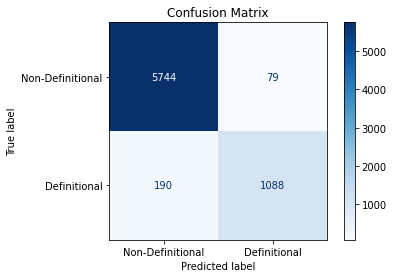


Final Model - Test Set Metrics:
AUC-ROC: 0.9189
Precision: 0.9323
Recall: 0.8513
F1-Score: 0.8900
F2-Score: 0.8664


In [3]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from setfit import SetFitModel
import matplotlib.pyplot as plt

test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
final_model_path = '/home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/final_trained_model'

test_data = pd.read_csv(test_split_path)

final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Definitional", "Definitional"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nFinal Model - Test Set Metrics:")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### ROC Curve and AUC-ROC Evaluation

AUC-ROC: 0.9187


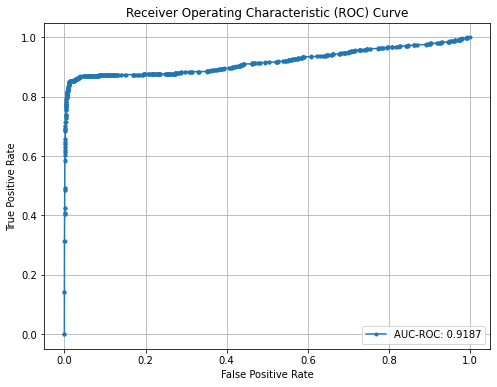

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from setfit import SetFitModel

model_path = '/home/roland/Projects/saras_folder/Data_Splitting/mpnetaugmentation/final_trained_model'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'

test_data = pd.read_csv(test_split_path)
model = SetFitModel.from_pretrained(model_path)

test_labels = test_data['definition_sentence'].tolist()
test_sentences = test_data['sentence_original'].tolist()

# Get probabilities for the test set
probabilities = model.predict_proba(test_sentences)
# Extract probabilities for definitional sentences
positive_probabilities = probabilities[:, 1]

test_auc = roc_auc_score(test_labels, positive_probabilities)
print(f"AUC-ROC: {test_auc:.4f}")

fpr, tpr, thresholds = roc_curve(test_labels, positive_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC: {test_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
